# I. Importing required libraries and data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-insincere-questions-classification/test.csv
/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip


In [2]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import roc_auc_score
import scikitplot as skplt
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
data_train = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/train.csv')
data_val = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/test.csv')
print(data_train.shape)
print(data_train.isnull().sum())
print(data_val.isnull().sum())
print(data_train['target'].value_counts())
data_train.head()

(1306122, 3)
qid              0
question_text    0
target           0
dtype: int64
qid              0
question_text    0
dtype: int64
0    1225312
1      80810
Name: target, dtype: int64


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


# II. Lemmatization

In [4]:
def lemmatize(data):
    lemmatizer = WordNetLemmatizer()
    lem_data = []
    for text in data:
        lem_text = ''
        for word in text.split():
            word = word.lower()
            lem_word = lemmatizer.lemmatize(word)
            lem_word = lemmatizer.lemmatize(lem_word, pos='v')
            lem_text = lem_text + ' ' + lem_word
        lem_data.append(lem_text)
    return lem_data
    

In [5]:
X = data_train['question_text']
y = data_train['target']
ques_id = data_val['qid']
X_val = data_val['question_text']
X_lem = lemmatize(X.tolist())
X_val = lemmatize(X_val.tolist())
X_lem[:10]

[' how do quebec nationalist see their province a a nation in the 1960s?',
 ' do you have an adopt dog, how would you encourage people to adopt and not shop?',
 ' why doe velocity affect time? doe velocity affect space geometry?',
 ' how do otto von guericke use the magdeburg hemispheres?',
 ' can i convert montra helicon d to a mountain bike by just change the tyres?',
 ' be gaza slowly become auschwitz, dachau or treblinka for palestinians?',
 ' why doe quora automatically ban conservative opinion when reported, but doe not do the same for liberal views?',
 ' be it crazy if i wash or wipe my grocery off? germ be everywhere.',
 ' be there such a thing a dress moderately, and if so, how be that different than dress modestly?',
 ' be it just me or have you ever be in this phase wherein you become ignorant to the people you once loved, completely disregard their feelings/lives so you get to have something go your way and feel temporarily at ease. how do thing change?']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_lem, y, random_state=0)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word2idx = tokenizer.word_index
vocab_size = len(word2idx)
max_len = 100
train_seq = tokenizer.texts_to_sequences(X_train)
train_pad = pad_sequences(train_seq, maxlen=max_len)
test_seq = tokenizer.texts_to_sequences(X_test)
test_pad = pad_sequences(test_seq, maxlen=max_len)
val_seq = tokenizer.texts_to_sequences(X_val)
val_pad = pad_sequences(val_seq, maxlen=max_len)

# III. Vectorization using Tfidf

In [7]:
tfidf = TfidfVectorizer(ngram_range=(1,3), min_df=5, max_df=0.9)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
X_val_tfidf = tfidf.transform(X_val)

# IV. Training the Classifier using RandomizedSearchCV

In [8]:
clf = LogisticRegression(max_iter=1000)
params = {
    'C':[0.001,0.01,0.1,1,10],
}
scorer=make_scorer(f1_score)
grid = RandomizedSearchCV(clf, params, scoring=scorer)
cv_results = grid.fit(X_train_tfidf, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [9]:
cv_results.best_params_

{'C': 10}

In [10]:
cv_results.cv_results_

{'mean_fit_time': array([  5.23496733,   8.85645571,  25.76194382,  68.82806392,
        172.17041254]),
 'std_fit_time': array([ 0.11950978,  0.45746321,  1.56980231,  6.77473731, 15.03716504]),
 'mean_score_time': array([0.08657622, 0.08668413, 0.09005713, 0.0901998 , 0.09209323]),
 'std_score_time': array([0.00036182, 0.0007741 , 0.00219665, 0.00145292, 0.00223254]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}],
 'split0_test_score': array([0.        , 0.0008225 , 0.30355742, 0.51234666, 0.56195615]),
 'split1_test_score': array([0.        , 0.00147953, 0.30268778, 0.51790751, 0.56619855]),
 'split2_test_score': array([0.        , 0.00082284, 0.29841729, 0.51305732, 0.56482383]),
 'split3_test_score': array([0.        , 0.00082223, 0.30428205, 0.51435267, 0.56371712]),
 'split4_test_score': arr

# V. Model prediction and evaluation

**Here, we use the ROC curve as a metric for evaluating our classification model. Since the dataset is imbalanced with high number of '0' labels as compared '1' labels, accuracy_score is an inappropriate metric as it tends to be biased towards the majority class. Hence, area under the ROC curve is used instead, whose value is between 0.5 and 1, and the higher, the better.**

In [11]:
best_clf = cv_results.best_estimator_
best_clf.fit(X_train_tfidf, y_train)
y_pred = best_clf.predict(X_test_tfidf)
print(y_pred)
y_val = best_clf.predict(X_val_tfidf)
y_val


[0 0 0 ... 0 1 0]


array([1, 0, 0, ..., 0, 0, 0])

In [12]:
y_prob = best_clf.predict_proba(X_test_tfidf)
pos_class_prob = [prob[1] for prob in y_prob]
print(roc_auc_score(y_test, pos_class_prob))


0.9534777284208868


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


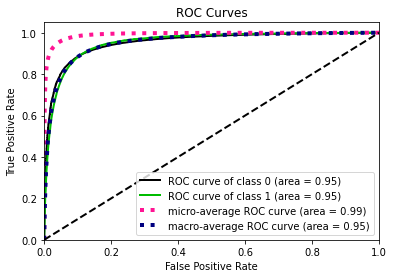

In [13]:
#Plotting ROC curve for test data.
skplt.metrics.plot_roc_curve(y_test, y_prob)
plt.show()

In [14]:
#Submitting predictions.
df = pd.DataFrame()
df['qid'] = ques_id
df['prediction'] = y_val
df.to_csv('submission.csv',index=False)
